# Transient photocurrent simulations

Effects of charge carrier traps on transient photocurrent in organic photovoltaic device is demonstrated. This notebook reproduces plot from Inchan Hwang, Christopher R. McNeill, Neil C. Greenham [Drift-diffusion modeling of photocurrent transients in bulk heterojunction solar cells](https://dx.doi.org/10.1063/1.3247547), J Appl Phys 106, 094506 (2009).

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from oedes import *

In [2]:
mesh = fvm.mesh1d(220e-9)

## Optical simulation

In [3]:
glass = optical.SimpleLayer(1e-3, 1.55)
ITO = optical.SimpleLayer(40e-9, 1.5 + 0.03j)
Al = optical.SimpleLayer(100e-9, 0.91 + 6.34j)

In [4]:
absorption = optical.SimpleAbsorption(
    mesh,
    1.75 + 0.49j,
    layers_before=[
        glass,
        ITO],
    layers_after=[Al],
    wavelength=525e-9)


def A(x):
    return absorption.normalized(mesh.length - x)

Text(0,0.5,'Normalized absorption')

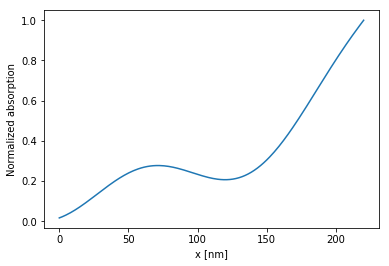

In [5]:
x = mesh.cells['center']
plt.plot(x * 1e9, A(x))
testing.store(x)
testing.store(A(x))
plt.xlabel('x [nm]')
plt.ylabel('Normalized absorption')

## Electrical simulation

In [6]:
model = models.BaseModel()
model.poisson = models.Poisson(mesh)
model.poisson.bc = [models.AppliedVoltage(k) for k in mesh.boundaries]
electron = models.add_transport(model, mesh, -1, 'electron')
hole = models.add_transport(model, mesh, 1, 'hole')
electrontrap0 = models.add_transport(
    model, mesh, -1, 'electron.trap0', dos_class=None)
exciton = models.add_transport(model, mesh, 0, 'exciton', dos_class=None)
for p in ['electron.trap0', 'exciton']:
    model.species_v_D[p] = models.species_v_D_not_transported
#electrontrap0.bc=[models.Zero(k) for k in mesh.boundaries]
#exciton.bc=[models.Zero(k) for k in mesh.boundaries]
electrontrap0.bc = []
exciton.bc = []
for p in ['electron', 'hole']:
    model.species_v_D[p] = models.species_v_D_FrenkelPoole
# for eq in [ electron, hole ]:
#    eq.bc=[models.FermiLevelEqualElectrode('electrode0'),models.FermiLevelEqualElectrode('electrode1')]
model.sources.append(
    models.TrapSource(
        electron,
        electrontrap0,
        fill_transport=False,
        rrate_param=True))


def gen(x):
    G0 = 1.63e26
    return G0 * A(x)


model.sources.append(models.SimpleGenerationTerm(exciton, gen))
model.sources.append(models.SimpleDecayTerm(exciton))
model.sources.append(
    models.OnsagerBraunRecombinationDissociationTerm(
        exciton, electron, hole))
# model.species_dos['electron']=models.BoltzmannDOS()
# model.species_dos['hole']=models.BoltzmannDOS()
model.setUp()

In [7]:
N0 = 1e27
default_params = {
    'T': 300.,
    'epsilon_r': 3.,
    'electron.mu0': 9.9e-8,
    'hole.mu0': 1.8e-8,
    'electron.gamma': 1.5e-5,
    'hole.gamma': -2.2e-4,
    'exciton.distance': 2.8e-9,
    'exciton.decay': 1.3e7,
    'electron.trap0.N0': 1.3e22,
    'electron.trap0.trate': 2.5e-16,
    'electron.trap0.rrate': 1e4 / N0,
    'electron.N0': N0,
    'hole.N0': N0,
    'exciton.absorption.I': 1.,
    'electron.level': 0.,
    'electrode0.workfunction': 0.5,
    'hole.level': 1.9,
    'electrode1.workfunction': 1.4,
    'electrode0.voltage': 0.,
    'electrode1.voltage': 0.,
    'npi': 0.
}

In [8]:
cic = context(model)


def run(I, p={}, t=100e-6, store=True):
    params = dict(default_params)
    params.update(p)
    params['exciton.absorption.I'] = 0.
    cic.solve(params)
    c = context(model, x=cic.x)
    params['exciton.absorption.I'] = I
    c.transient(dict(params), 1. * t, 1e-9)
    params['exciton.absorption.I'] = 0.
    c.transient(dict(params), 5. * t, 1e-9)
    t, j = c.teval('time', 'J')
    if store:
        testing.store(t, atol=1e-12)
        testing.store(j, atol=1e-12)
    return c, t, j

### Fig. 6

In [9]:
import matplotlib.pylab as plt

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

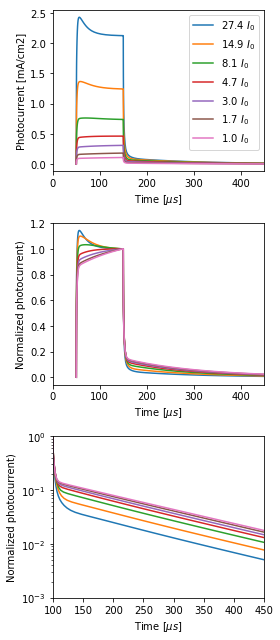

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(4, 9))
for I in [1., 1.7, 3., 4.7, 8.1, 14.9, 27.4][::-1]:
    c, t, j = run(I)
    ax1.plot(t * 1e6 + 50, j * 0.1, label='%.1f $I_0$' % I)
    jn = c.attime(99e-6).output()['J']
    ax2.plot(t * 1e6 + 50, j / jn)
    ax3.plot(t * 1e6, j / jn)
ax3.set_yscale('log')
for a in [ax1, ax2, ax3]:
    a.set_xlabel(r'Time [$\mu s$]')
    a.set_xlim([0, 450])
for a in [ax1]:
    a.set_ylabel('Photocurrent [mA/cm2]')
for a in [ax2, ax3]:
    a.set_ylabel('Normalized photocurrent)')
ax3.set_ylim([1e-3, 1])
ax3.set_xlim([100, 450])
ax1.legend(loc='upper right')
fig.tight_layout()

### Fig. 7a

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

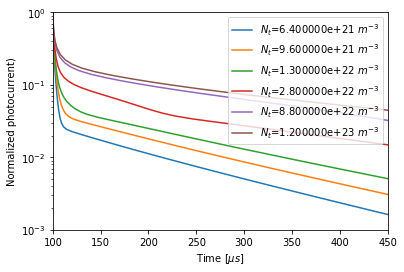

In [11]:
ax = plt.gca()
for Nt in [6.4e21, 9.6e21, 1.3e22, 2.8e22, 8.8e22, 1.2e23]:
    c, t, j = run(27.4, {'electron.trap0.N0': Nt})
    jn = c.attime(99e-6).output()['J']
    ax.plot(t * 1e6, j / jn, label=r'$N_t$=%e $m^{-3}$' % Nt)
ax.set_xlabel(r'Time [$\mu s$]')
ax.set_ylabel('Normalized photocurrent)')
ax.set_ylim([1e-3, 1])
ax.set_xlim([100, 450])
ax.set_yscale('log')
ax.legend(loc='upper right')

### Fig. 7b

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

 time=0.0005                

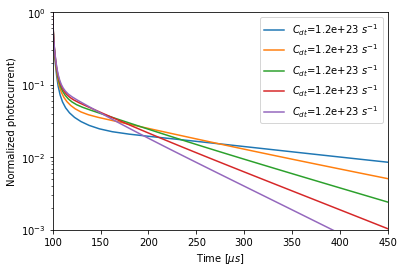

In [12]:
ax = plt.gca()
Nt = 1.2e23
for Cdt in [5e3, 1e4, 1.5e4, 2e4, 2.5e4]:
    c, t, j = run(27.4, {'electron.trap0.rrate': Cdt / N0})
    jn = c.attime(99e-6).output()['J']
    ax.plot(t * 1e6, j / jn, label=r'$C_{dt}$=%.1e $s^{-1}$' % Nt)
ax.set_xlabel(r'Time [$\mu s$]')
ax.set_ylabel('Normalized photocurrent)')
ax.set_ylim([1e-3, 1])
ax.set_xlim([100, 450])
ax.set_yscale('log')
ax.legend(loc='upper right')

### Fig. 9a

 time=0.0025                

 time=0.0025                

 time=0.0025                

 time=0.0025                

 time=0.0025                

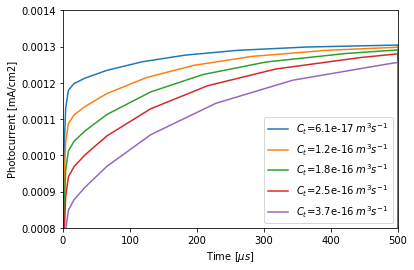

In [13]:
ax = plt.gca()
for Ct in [6.1e-17, 1.2e-16, 1.8e-16, 2.5e-16, 3.7e-16]:
    c, t, j = run(1e-2, {'electron.trap0.trate': Ct}, t=500e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$C_{t}$=%.1e $m^3 s^{-1}$' % Ct)
ax.set_xlabel(r'Time [$\mu s$]')
ax.set_ylabel('Photocurrent [mA/cm2]')
ax.set_ylim([0.8e-3, 1.4e-3])
ax.set_xlim([0, 500])
ax.legend(loc='lower right')

### Fig. 9b

 time=0.0025                

 time=0.0025                

 time=0.0025                

 time=0.0025                

 time=0.0025                

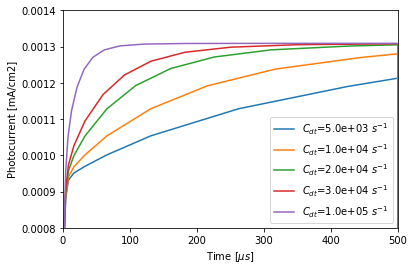

In [14]:
ax = plt.gca()
for Cdt in [5e3, 1e4, 2e4, 3e4, 1e5]:
    c, t, j = run(1e-2, {'electron.trap0.rrate': Cdt / N0}, t=500e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$C_{dt}$=%.1e $s^{-1}$' % Cdt)
ax.set_xlabel(r'Time [$\mu s$]')
ax.set_ylabel('Photocurrent [mA/cm2]')
ax.set_ylim([0.8e-3, 1.4e-3])
ax.set_xlim([0, 500])
ax.legend(loc='lower right')

### Fig. 8a

 time=0.0025                

 time=0.0025                

 time=0.0025                

 time=0.0025                

 time=0.0025                

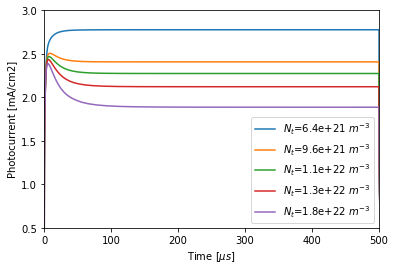

In [15]:
ax = plt.gca()
for Nt in [6.4e21, 9.6e21, 1.1e22, 1.3e22, 1.8e22]:
    c, t, j = run(27.4, {'electron.trap0.N0': Nt,
                         'electron.trap0.trate': 3.2e6 / Nt}, t=500e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$N_t$=%.1e $m^{-3}$' % Nt)
ax.set_xlabel(r'Time [$\mu s$]')
ax.set_ylabel('Photocurrent [mA/cm2]')
ax.set_ylim([0.5, 3])
ax.set_xlim([0, 500])
ax.legend(loc='lower right')

### Fig. 8b

 time=0.001                 

 time=0.001                 

 time=0.001                 

 time=0.001                 

 time=0.001                 

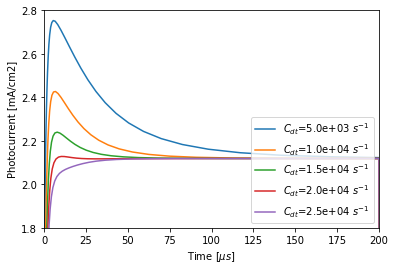

In [16]:
ax = plt.gca()
for Cdt in [5e3, 1e4, 1.5e4, 2e4, 2.5e4]:
    c, t, j = run(27.4, {'electron.trap0.rrate': Cdt / N0,
                         'electron.trap0.trate': 2.5e-16 / 1e4 * Cdt}, t=200e-6)
    ax.plot(t * 1e6, j * 0.1, label=r'$C_{dt}$=%.1e $s^{-1}$' % Cdt)
ax.set_xlabel(r'Time [$\mu s$]')
ax.set_ylabel('Photocurrent [mA/cm2]')
ax.set_ylim([1.8, 2.8])
ax.set_xlim([0, 200])
ax.legend(loc='lower right')

### Fig. 11 and 12

 time=0.0005                

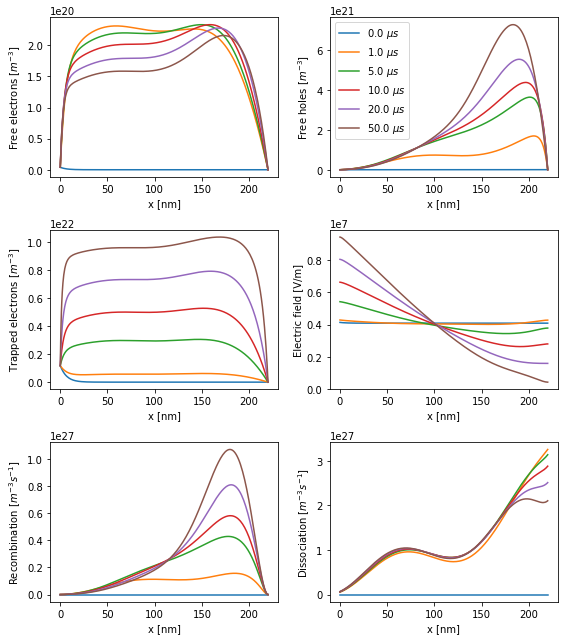

In [17]:
r = []
fig, ((nf, pf), (nt, e), (r, d)) = plt.subplots(3, 2, figsize=(8, 9))
c = run(27.4, store=False)[0]
for t in [0e-6, 1e-6, 5e-6, 10e-6, 20e-6, 50e-6]:
    o = c.attime(t).output()

    def _p(ax, y, x=mesh.cells['center']):
        testing.store(y, rtol=1e-4)
        ax.plot(x * 1e9, y, label=r'%.1f $\mu s$' % (t * 1e6))
    _p(nt, o['electron.trap0.c'])
    _p(nf, o['electron.c'])
    _p(pf, o['hole.c'])
    _p(e, o['E'], x=mesh.faces['center'])
    _p(r, o['exciton.dissociation.recombination'])
    _p(d, o['exciton.dissociation.dissociation'])
nt.set_ylabel('Trapped electrons [$m^{-3}$]')
nf.set_ylabel('Free electrons [$m^{-3}$]')
pf.set_ylabel('Free holes [$m^{-3}$]')
e.set_ylabel('Electric field [V/m]')
r.set_ylabel('Recombination [$m^{-3} s^{-1}$]')
d.set_ylabel('Dissociation [$m^{-3} s^{-1}$]')
pf.legend(loc='upper left')
for a in [nf, pf, nt, e, r, d]:
    a.set_xlabel('x [nm]')
plt.tight_layout()
r = np.asarray(r)


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
